# **Kolmogorov Arnold Network(KAN) + MobileNetV2**

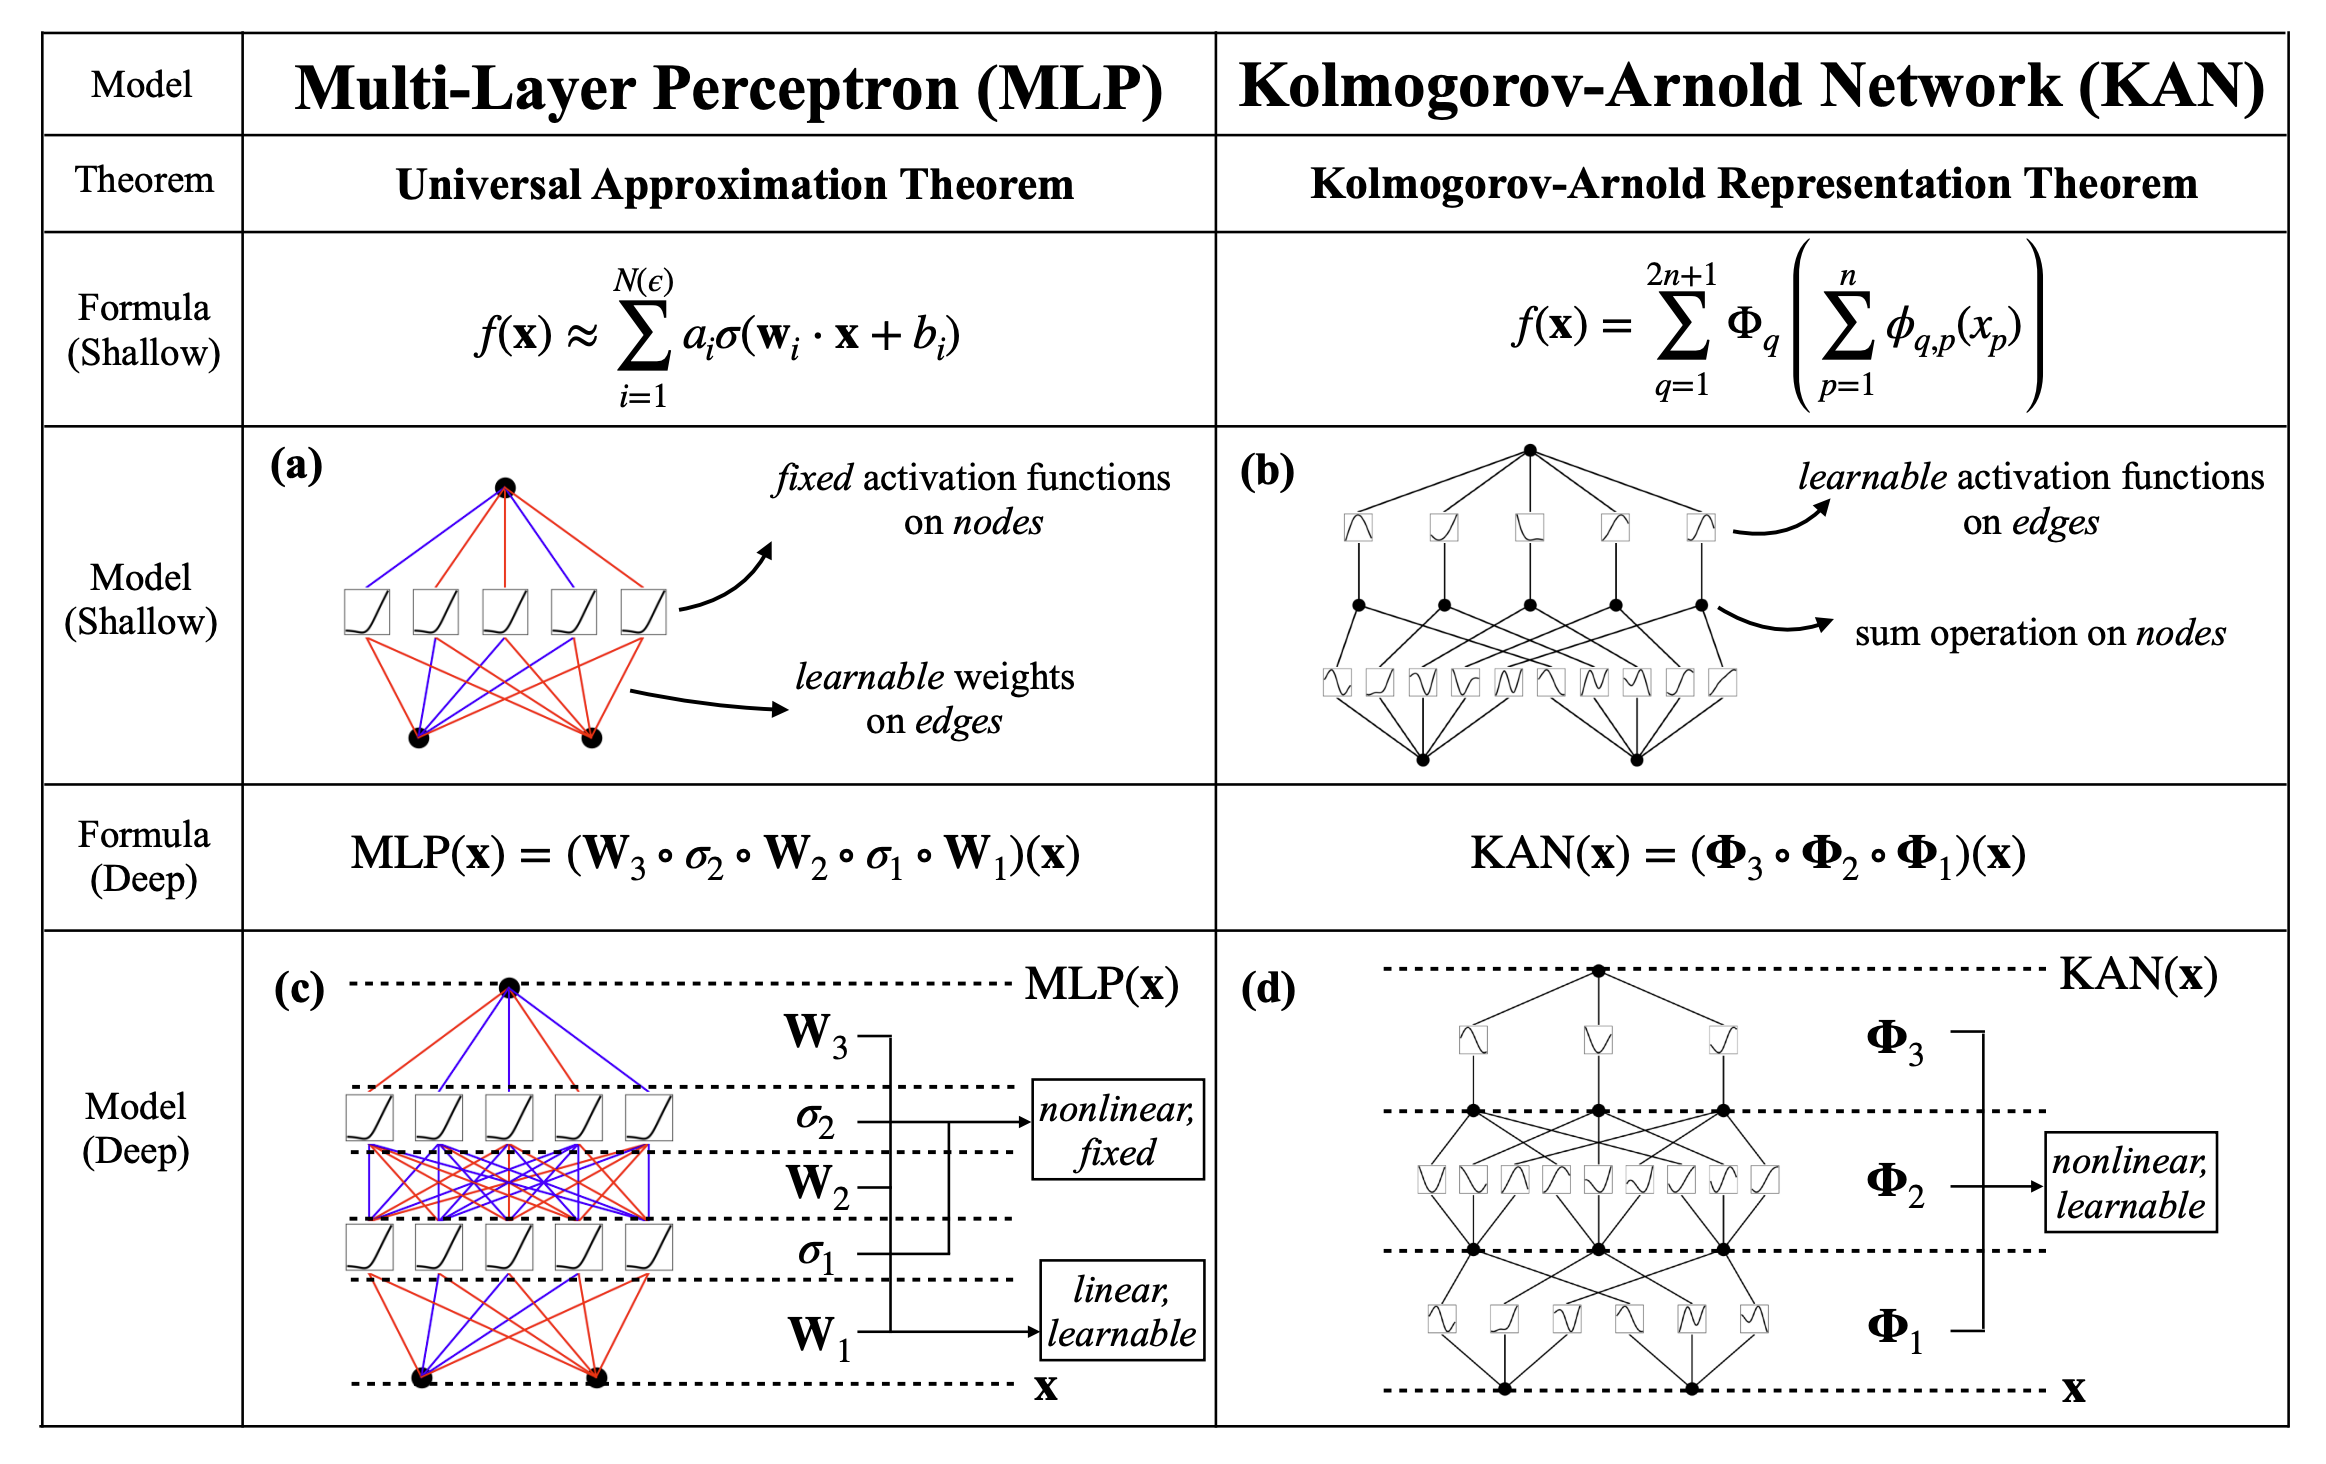

## **[KAN Implementation](https://github.com/Blealtan/efficient-kan/tree/master)**

## Dataset : Dog Cat 

### **1. Model-1 : MobileNetV2 with MLP as FC(Classifier Layer)**

### **2. Model-2 : MobileNetV2 with KAN as FC(Classifier Layer)**

In [9]:
# Standard library
import copy
import glob
import multiprocessing
import os
import time
import zipfile

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Related third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [7]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "/kaggle/input/kan-implement/kan.py", dst = "../working/kan.py")

'../working/kan.py'

In [8]:
# import all our functions
from kan import KAN

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

## **Dataset and DataLoader Preparation**

In [12]:
input_size = (224,224)
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

In [13]:
transform = transforms.Compose([
    transforms.Resize(input_size),  # Resize to a fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [14]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, folder_name in enumerate(['Dog', 'Cat']):
            folder_path = os.path.join(self.root_dir, folder_name)
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                
                try:
                    with Image.open(file_path) as img:
                        
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        
                        if img.mode != 'RGB':
                            print(f"Skipping {file_path} because it does not have 3 channels (RGB)")
                            continue

                        self.image_paths.append(file_path)
                        self.labels.append(label)
                        
                except Exception as e:
                    print(f"Skipping {file_path} due to error: {e}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        with Image.open(image_path) as img:

            if img.mode != 'RGB':
                img = img.convert('RGB')

            if self.transform:
                img = self.transform(img)
            
        return img, label


In [15]:
dataset = CustomDataset(root_dir='/kaggle/input/microsoft-catsvsdogs-dataset/PetImages', transform=transform)

# Calculate split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset into train and test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg due to error: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg'
Skipping /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/Thumbs.db due to error: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/Thumbs.db'
Skipping /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db due to error: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/Thumbs.db'
Skipping /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg due to error: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg'


In [18]:
# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [19]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 3, 224, 224])
torch.Size([128])


In [20]:
def train_epoch(model, criterion, optimizer, data_loader, device,epoch):
    model.train()
    
    epoch_loss = 0.0
    num_batches = len(data_loader)
    
    for batch_idx, (image, target) in enumerate(tqdm(data_loader)):
        image, target = image.to(device), target.to(device)
        
        output = model(image)
        
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch = {epoch+1} || Training Loss: {avg_epoch_loss:.4f}")
    

In [21]:
def evaluate(model, criterion, data_loader, device,epoch):
    
    model.eval()
    
    epoch_loss = 0.0
    
    correct_predictions = 0
    total_predictions = 0
    
    num_batches = len(data_loader)
    
    with torch.no_grad():
       
        for image, target in tqdm(data_loader):
            image, target = image.to(device), target.to(device)
            output = model(image)
            loss = criterion(output, target)
            # Accumulate batch loss
            epoch_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(output, 1)  # Get the predicted class index
            correct_predictions += (predicted == target).sum().item()
            total_predictions += target.size(0)
            
    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / num_batches
    accuracy = correct_predictions / total_predictions
    
    print(f"Epoch = {epoch+1} || Test Loss: {avg_epoch_loss:.4f} || Test Accuracy: {accuracy:.4f}")
        

## **Pretrained MobileNetV2 + MLP as FC**

In [38]:
class MobileNet(torch.nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')  
        
        for param in self.model.parameters():
            param.requires_grad = False
            
        
        
        self.model.classifier[1] = nn.Sequential(
            nn.Linear(in_features=self.model.classifier[1].in_features,out_features=256),
            nn.SiLU(inplace=False),
            nn.BatchNorm1d(num_features=256),
            nn.Dropout(p=0.2,inplace=False),
            nn.Linear(in_features=256,out_features=2),
            nn.Softmax(dim=1))
      
        
        # print(self.model)

    def forward(self, x):
        x = self.model(x)
        return x

In [39]:
model = MobileNet().to(device)

In [40]:
print_model_size(model)

10.45 MB


In [41]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001,weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [42]:
for nepoch in range(5):
    train_epoch(model, criterion, optimizer, train_loader, device,nepoch)
    
    evaluate(model,criterion, test_loader,device,nepoch)
    

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 1 || Training Loss: 0.3535


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 1 || Test Loss: 0.3450 || Test Accuracy: 0.9674


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 2 || Training Loss: 0.3450


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 2 || Test Loss: 0.3431 || Test Accuracy: 0.9706


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 3 || Training Loss: 0.3441


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 3 || Test Loss: 0.3386 || Test Accuracy: 0.9732


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 4 || Training Loss: 0.3404


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 4 || Test Loss: 0.3373 || Test Accuracy: 0.9744


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 5 || Training Loss: 0.3399


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 5 || Test Loss: 0.3380 || Test Accuracy: 0.9762


## **Pretrained MobileNetV2 + KAN as FC**

In [22]:
class MobileNet(torch.nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')  
        
        for param in self.model.parameters():
            param.requires_grad = False
            
        
        
        self.model.classifier[1] = nn.Sequential(
            KAN([self.model.classifier[1].in_features, 256, 2]))
      
        
        # print(self.model)

    def forward(self, x):
        x = self.model(x)
        return x

In [23]:
model = MobileNet()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 7.58MB/s]


In [24]:
x = torch.rand(1,3,224,224)
model.eval()
op = model(x)
print(op)

tensor([[ 0.0727, -0.0033]], grad_fn=<AddBackward0>)


In [34]:
model.to(device)

MobileNet(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1)

In [35]:
print_model_size(model)

22.33 MB


In [36]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001,weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [37]:
for nepoch in range(5):
    train_epoch(model, criterion, optimizer, train_loader, device,nepoch)
    
    evaluate(model,criterion, test_loader,device,nepoch)
    

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 1 || Training Loss: 0.1168


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch = 1 || Test Loss: 0.0744 || Test Accuracy: 0.9754


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 2 || Training Loss: 0.0786


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 2 || Test Loss: 0.0684 || Test Accuracy: 0.9732


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 3 || Training Loss: 0.0704


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 3 || Test Loss: 0.0813 || Test Accuracy: 0.9640


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 4 || Training Loss: 0.0673


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 4 || Test Loss: 0.0722 || Test Accuracy: 0.9694


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch = 5 || Training Loss: 0.0678


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 5 || Test Loss: 0.0631 || Test Accuracy: 0.9750
